In [140]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [108]:
partidas_realizadas = pd.read_csv('/home/frank/workspace/ml-brasileirao-serie-a/data/raw/Partidas_Realizadas.csv')
partidas_realizadas = partidas_realizadas.dropna(subset=['Data'])
partidas_realizadas = partidas_realizadas[partidas_realizadas['Placar_Visitante'] != 'X']
partidas_realizadas.head()

,Rodada,Mandante,Placar_Mandante,Placar_Visitante,Visitante,Estadio,Data,Dia,Hora
0,1,Vitória,0,1,Palmeiras,Barradão,14/04,Domingo,18:30
1,1,Internacional,2,1,Bahia,Beira-Rio,13/04,Sábado,18:30
2,1,Criciúma,1,1,Juventude,Heriberto Hülse,13/04,Sábado,18:30
3,1,Fluminense,2,2,Bragantino,Maracanã,13/04,Sábado,21:00
4,1,São Paulo,1,2,Fortaleza,Morumbis,13/04,Sábado,21:00


In [99]:
partidas_realizadas.isnull().sum()

Rodada              0
Mandante            0
Placar_Mandante     0
Placar_Visitante    0
Visitante           0
Estadio             0
Data                0
Dia                 0
Hora                0
dtype: int64

In [94]:
classificacao = pd.read_csv('/home/frank/workspace/ml-brasileirao-serie-a/data/raw/Classificacao.csv')
classificacao.head()

,Rodada,Time,Posicao,Pontos,Jogos,Vitorias,Empates,Derrotas,GP,GC,SG
0,29,Botafogo,1,60,29,18,6,5,47,25,22
1,29,Palmeiras,2,57,29,17,6,6,46,20,26
2,29,Fortaleza,3,55,29,16,7,6,38,29,9
3,29,Flamengo,4,51,28,15,6,7,45,32,13
4,29,São Paulo,5,47,29,14,5,10,38,32,6


In [7]:
partidas_nao_realizadas = pd.read_csv('/home/frank/workspace/ml-brasileirao-serie-a/data/raw/Partidas_Nao_Realizadas.csv')
partidas_nao_realizadas.head()

,Rodada,Mandante,Visitante,Data
0,28,Internacional,Grêmio,20/10
1,28,Cruzeiro,Bahia,20/10
2,28,Vitória,Bragantino,20/10
3,28,Flamengo,Fluminense,20/10
4,28,Botafogo,Criciúma,20/10


In [8]:
partidas_realizadas.drop(columns=['Estadio'])

,Rodada,Mandante,Placar_Mandante,Placar_Visitante,Visitante,Data,Dia,Hora
0,1,Vitória,0,1,Palmeiras,14/04,Domingo,18:30
1,1,Internacional,2,1,Bahia,13/04,Sábado,18:30
2,1,Criciúma,1,1,Juventude,13/04,Sábado,18:30
3,1,Fluminense,2,2,Bragantino,13/04,Sábado,21:00
4,1,São Paulo,1,2,Fortaleza,13/04,Sábado,21:00
...,...,...,...,...,...,...,...,...
285,29,Bragantino,0,0,Palmeiras,05/10,Sábado,16:30
286,29,Atlético-MG,2,2,Vitória,05/10,Sábado,16:30
287,29,Grêmio,3,1,Fortaleza,04/10,Sexta,21:30
288,29,Fluminense,1,0,Cruzeiro,03/10,Quinta,21:30


In [109]:
partidas_realizadas['data_hora'] = pd.to_datetime(partidas_realizadas['Data'] + '/2024' + ' ' + partidas_realizadas['Hora'], format='%d/%m/%Y %H:%M')
#partidas_realizadas = partidas_realizadas.drop(columns=["Data", "Hora", "Estadio"])

dias_da_semana_para_numero = { 'Segunda': 0, 'Terça': 1, 'Quarta': 2, 'Quinta': 3, 'Sexta': 4, 'Sábado': 5, 'Domingo': 6}
partidas_realizadas['Dia'] = partidas_realizadas['Dia'].replace(dias_da_semana_para_numero)
partidas_realizadas['Dia'] = pd.to_numeric(partidas_realizadas['Dia'], errors='coerce')

partidas_realizadas['Placar_Mandante'] = pd.to_numeric(partidas_realizadas['Placar_Mandante'])
partidas_realizadas['Placar_Visitante'] = pd.to_numeric(partidas_realizadas['Placar_Visitante'])

def determinar_resultado(row):
    if row['Placar_Mandante'] > row['Placar_Visitante']:
        return 0  # Ganhou
    elif row['Placar_Mandante'] < row['Placar_Visitante']:
        return 2  # Perdeu
    else:
        return 1  # Empatou

def foi_goleada(row):
    if abs(row['Placar_Mandante'] - row['Placar_Visitante']) >= 3:
        return 1  # Foi goleada
    else:
        return 0  # Não foi goleada    

partidas_realizadas['resultado'] = partidas_realizadas.apply(determinar_resultado, axis=1)
partidas_realizadas['goleada'] = partidas_realizadas.apply(foi_goleada, axis=1)
partidas_realizadas['diferenca_placar'] = partidas_realizadas['Placar_Mandante'] - partidas_realizadas['Placar_Visitante']

partidas_realizadas = partidas_realizadas.drop(columns=["Placar_Mandante", "Placar_Visitante", "Estadio", "Data", "Hora"])
partidas_realizadas.head()

,Rodada,Mandante,Visitante,Dia,data_hora,resultado,goleada,diferenca_placar
0,1,Vitória,Palmeiras,6.0,2024-04-14 18:30:00,2,0,-1
1,1,Internacional,Bahia,5.0,2024-04-13 18:30:00,0,0,1
2,1,Criciúma,Juventude,5.0,2024-04-13 18:30:00,1,0,0
3,1,Fluminense,Bragantino,5.0,2024-04-13 21:00:00,1,0,0
4,1,São Paulo,Fortaleza,5.0,2024-04-13 21:00:00,2,0,-1


In [110]:
from sklearn.preprocessing import LabelEncoder

le_mandante = LabelEncoder()
le_visitante = LabelEncoder()

partidas_realizadas['Mandante'] = le_mandante.fit_transform(partidas_realizadas['Mandante'])
partidas_realizadas['Visitante'] = le_visitante.fit_transform(partidas_realizadas['Visitante'])


In [122]:
partidas_realizadas['data_hora'] = partidas_realizadas['data_hora'].astype(np.int64)
partidas_realizadas.head()

,Rodada,Mandante,Visitante,Dia,data_hora,resultado,goleada,diferenca_placar
0,1,19,16,6.0,1713119400000000000,2,0,-1
1,1,14,3,5.0,1713033000000000000,0,0,1
2,1,7,15,5.0,1713033000000000000,1,0,0
3,1,11,5,5.0,1713042000000000000,1,0,0
4,1,17,12,5.0,1713042000000000000,2,0,-1


/home/frank/.local/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
/home/frank/.local/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


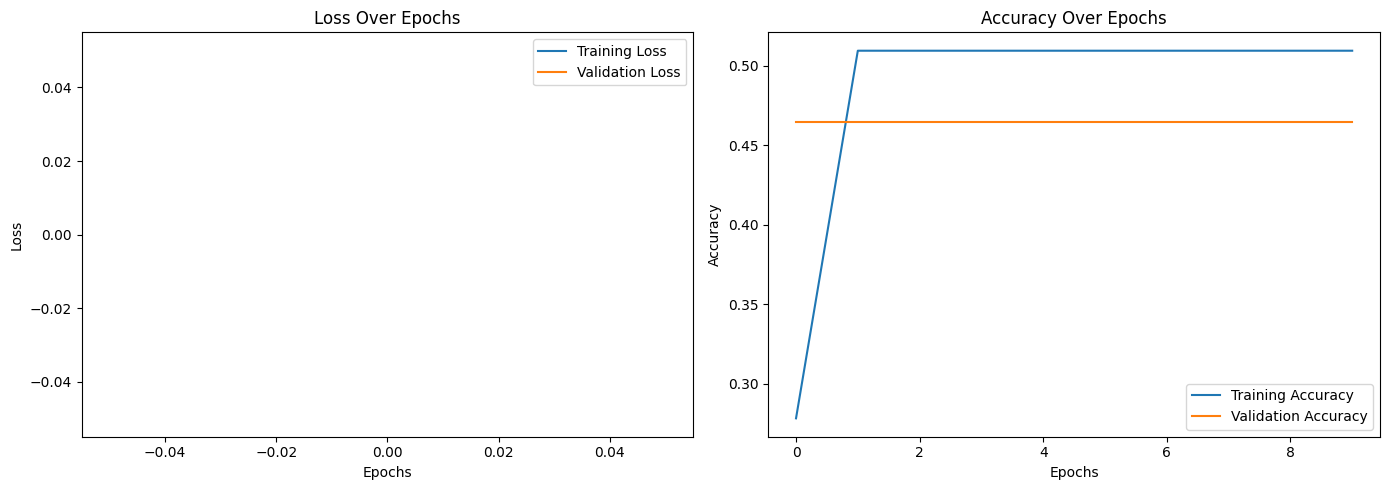

In [156]:
# Separando as características e os rótulos
X = partidas_realizadas.drop(columns=['resultado', 'goleada', 'diferenca_placar'])  # Características
y = partidas_realizadas['resultado']  # Rótulo

# Convertendo os rótulos para categorias
#y = to_categorical(partidas_realizadas['resultado'])

# Dividindo em conjuntos de treinamento e teste
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# Criando a rede neural
# model = Sequential()
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu', input_shape=[4]))
# model.add(Dropout(0.2))  # Adicionando Dropout
# model.add(Dense(64, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # Para múltiplas classes

input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='softmax'),  # Sigmoid for binary classification
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Compilando o modelo
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)
import matplotlib.pyplot as plt

# Convert the history object into a DataFrame for easier plotting
history_df = pd.DataFrame(history.history)

# Plotting Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
